In [1]:
import os,sys,re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from itertools import product
#import pickle5 # Need pickle5 for DataFrame pickles
from scipy.stats import linregress,sem
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mue
import seaborn as sns
from natsort import natsorted as ns
from natsort import *
import matplotlib as mpl
import multiprocessing as mp
cpus = mp.cpu_count()
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import log


In [3]:
# VAV pathnames
datadir = '../../data'

UseRosettaPub = True

A8 = pd.read_pickle( f'{datadir}/EE/A8_RBFE.pkl')
A13 = pd.read_pickle( f'{datadir}/EE/A13_RBFE.pkl').fillna(0)
A18 = pd.read_pickle( f'{datadir}/EE/A18_RBFE.pkl')
A8_var = pd.read_pickle( f'{datadir}/EE/A8_variance.pkl')
A13_var = pd.read_pickle( f'{datadir}/EE/A13_variance.pkl').fillna(0)
A18_var = pd.read_pickle( f'{datadir}/EE/A18_variance.pkl')
on = False
if on:
    for col in A8.columns:
        A8[col] = np.mean(A8[col].values+np.random.randn(100000,len(A8[col]))*A8_var[col].values,axis=0)
    for col in A18.columns:
        A18[col] = np.mean(A18[col].values+np.random.randn(100000,len(A18[col]))*A18_var[col].values,axis=0)
    for col in A13.columns:
        A13[col] = np.mean(A13[col].values+np.random.randn(100000,len(A13[col]))*A13_var[col].values,axis=0)

A8_old = pd.read_pickle( f'{datadir}/old_EE/A8_RBFE.pkl').fillna(0)
A13_old = pd.read_pickle( f'{datadir}/old_EE/A13_RBFE.pkl').fillna(0)
A18_old = pd.read_pickle( f'{datadir}/old_EE/A18_RBFE.pkl').fillna(0)
old_A8_var = pd.read_pickle( f'{datadir}/old_EE/A8_variance.pkl').fillna(0)
old_A13_var = pd.read_pickle( f'{datadir}/old_EE/A13_variance.pkl').fillna(0)
old_A18_var = pd.read_pickle( f'{datadir}/old_EE/A18_variance.pkl').fillna(0)

#A8_exp = pd.read_csv('A8_initial_Log10Kd_estimates_20230913.csv')
A8_exp = pd.read_pickle( f'{datadir}/Experiment/A8_exp_dg.pkl').reindex(A8.index).fillna(0)
A8_exp_unc = pd.read_pickle( f'{datadir}/Experiment/A8_exp_unc.pkl').reindex(A8.index).fillna(0)
A8_seq = open( f'{datadir}/sequences/A8_sequence.afasta').readlines()[0].replace('\n','')
#A8_exp=transform_exp(A8_exp,A8_seq)
A8_seq =[f'{A8_seq[i]}{270+i}' for i in range(len(A8_seq))]


#A18_exp = pd.read_csv('A18_initial_Log10Kd_estimates_20230913.csv')
A18_exp = pd.read_pickle( f'{datadir}/Experiment/A18_exp_dg.pkl').reindex(A18.index).fillna(0)
A18_exp_unc = pd.read_pickle( f'{datadir}/Experiment/A18_exp_unc.pkl').reindex(A18.index).fillna(0)
A18_seq = open( f'{datadir}/sequences/A18_sequence.afasta').readlines()[0].replace('\n','')
#A18_exp=transform_exp(A18_exp,A18_seq)
A18_seq=[f'{A18_seq[i]}{270+i}' for i in range(len(A18_seq))]


#A13_exp = pd.read_csv('A13_initial_Log10Kd_estimates_20230913.csv')
A13_exp = pd.read_pickle( f'{datadir}/Experiment/A13_exp_dg.pkl').reindex(A13.index).fillna(0)
A13_exp_unc = pd.read_pickle( f'{datadir}/Experiment/A13_exp_unc.pkl').reindex(A13.index).fillna(0)
A13_seq = open( f'{datadir}/sequences/A13_sequence.afasta').readlines()[0].replace('\n','')
#A13_exp=transform_exp(A13_exp,A13_seq)
A13_seq =[f'{A13_seq[i]}{270+i}' for i in range(len(A13_seq))]

if (UseRosettaPub):
    # Fix Rosetta A8 Df
    A8_ros_pub = pd.read_csv( f'{datadir}/published_rosetta/norm_final_A8_rosetta.csv')
    A8_ros_pub = A8_ros_pub.rename(columns={A8_ros_pub.columns[0]:''}) 
    A8_ros_pub.set_index(A8_ros_pub.columns[0],inplace=True)
    
    # Fix Rosetta A13 Df
    A13_ros_pub = pd.read_csv( f'{datadir}/published_rosetta/norm_final_A13_rosetta.csv')
    A13_ros_pub = A13_ros_pub.rename(columns={A13_ros_pub.columns[0]:''}) 
    A13_ros_pub.set_index(A13_ros_pub.columns[0],inplace=True)
    
    # Fix Rosetta A18 Df
    A18_ros_pub = pd.read_csv( f'{datadir}/published_rosetta/norm_final_A18_rosetta.csv')
    A18_ros_pub = A18_ros_pub.rename(columns={A18_ros_pub.columns[0]:''}) 
    A18_ros_pub.set_index(A18_ros_pub.columns[0],inplace=True)
    
    A8_ros_pub = A8_ros_pub * -1
    A13_ros_pub = A13_ros_pub * -1
    A18_ros_pub = A18_ros_pub * -1

A8_curr_ros = pd.read_csv( f'{datadir}/current_rosetta/A8_current_rosetta.csv')
A13_curr_ros = pd.read_csv( f'{datadir}/current_rosetta/A13_current_rosetta.csv')
A18_curr_ros = pd.read_csv( f'{datadir}/current_rosetta/A18_current_rosetta.csv')


def make_df(output,temp):
    output = output[output['state']=='ddg']
    index = list(temp.index)
    columns = temp.columns
    array = np.zeros(shape=(len(index),len(columns)))
    temp = pd.DataFrame(array,index=index,columns=columns)
    for index,row in output.iterrows():
        _col = row['position_label']
        _mut = row['mutation'][-1]
        _val = row['total_score']
        temp[_col][_mut]+=_val
    return temp

if (UseRosettaPub):
    A8_curr_ros = make_df(A8_curr_ros,A8_ros_pub.copy())
    A13_curr_ros = make_df(A13_curr_ros,A13_ros_pub.copy())
    A18_curr_ros = make_df(A18_curr_ros,A18_ros_pub.copy())

# Heatmaps for All (figure 5.)

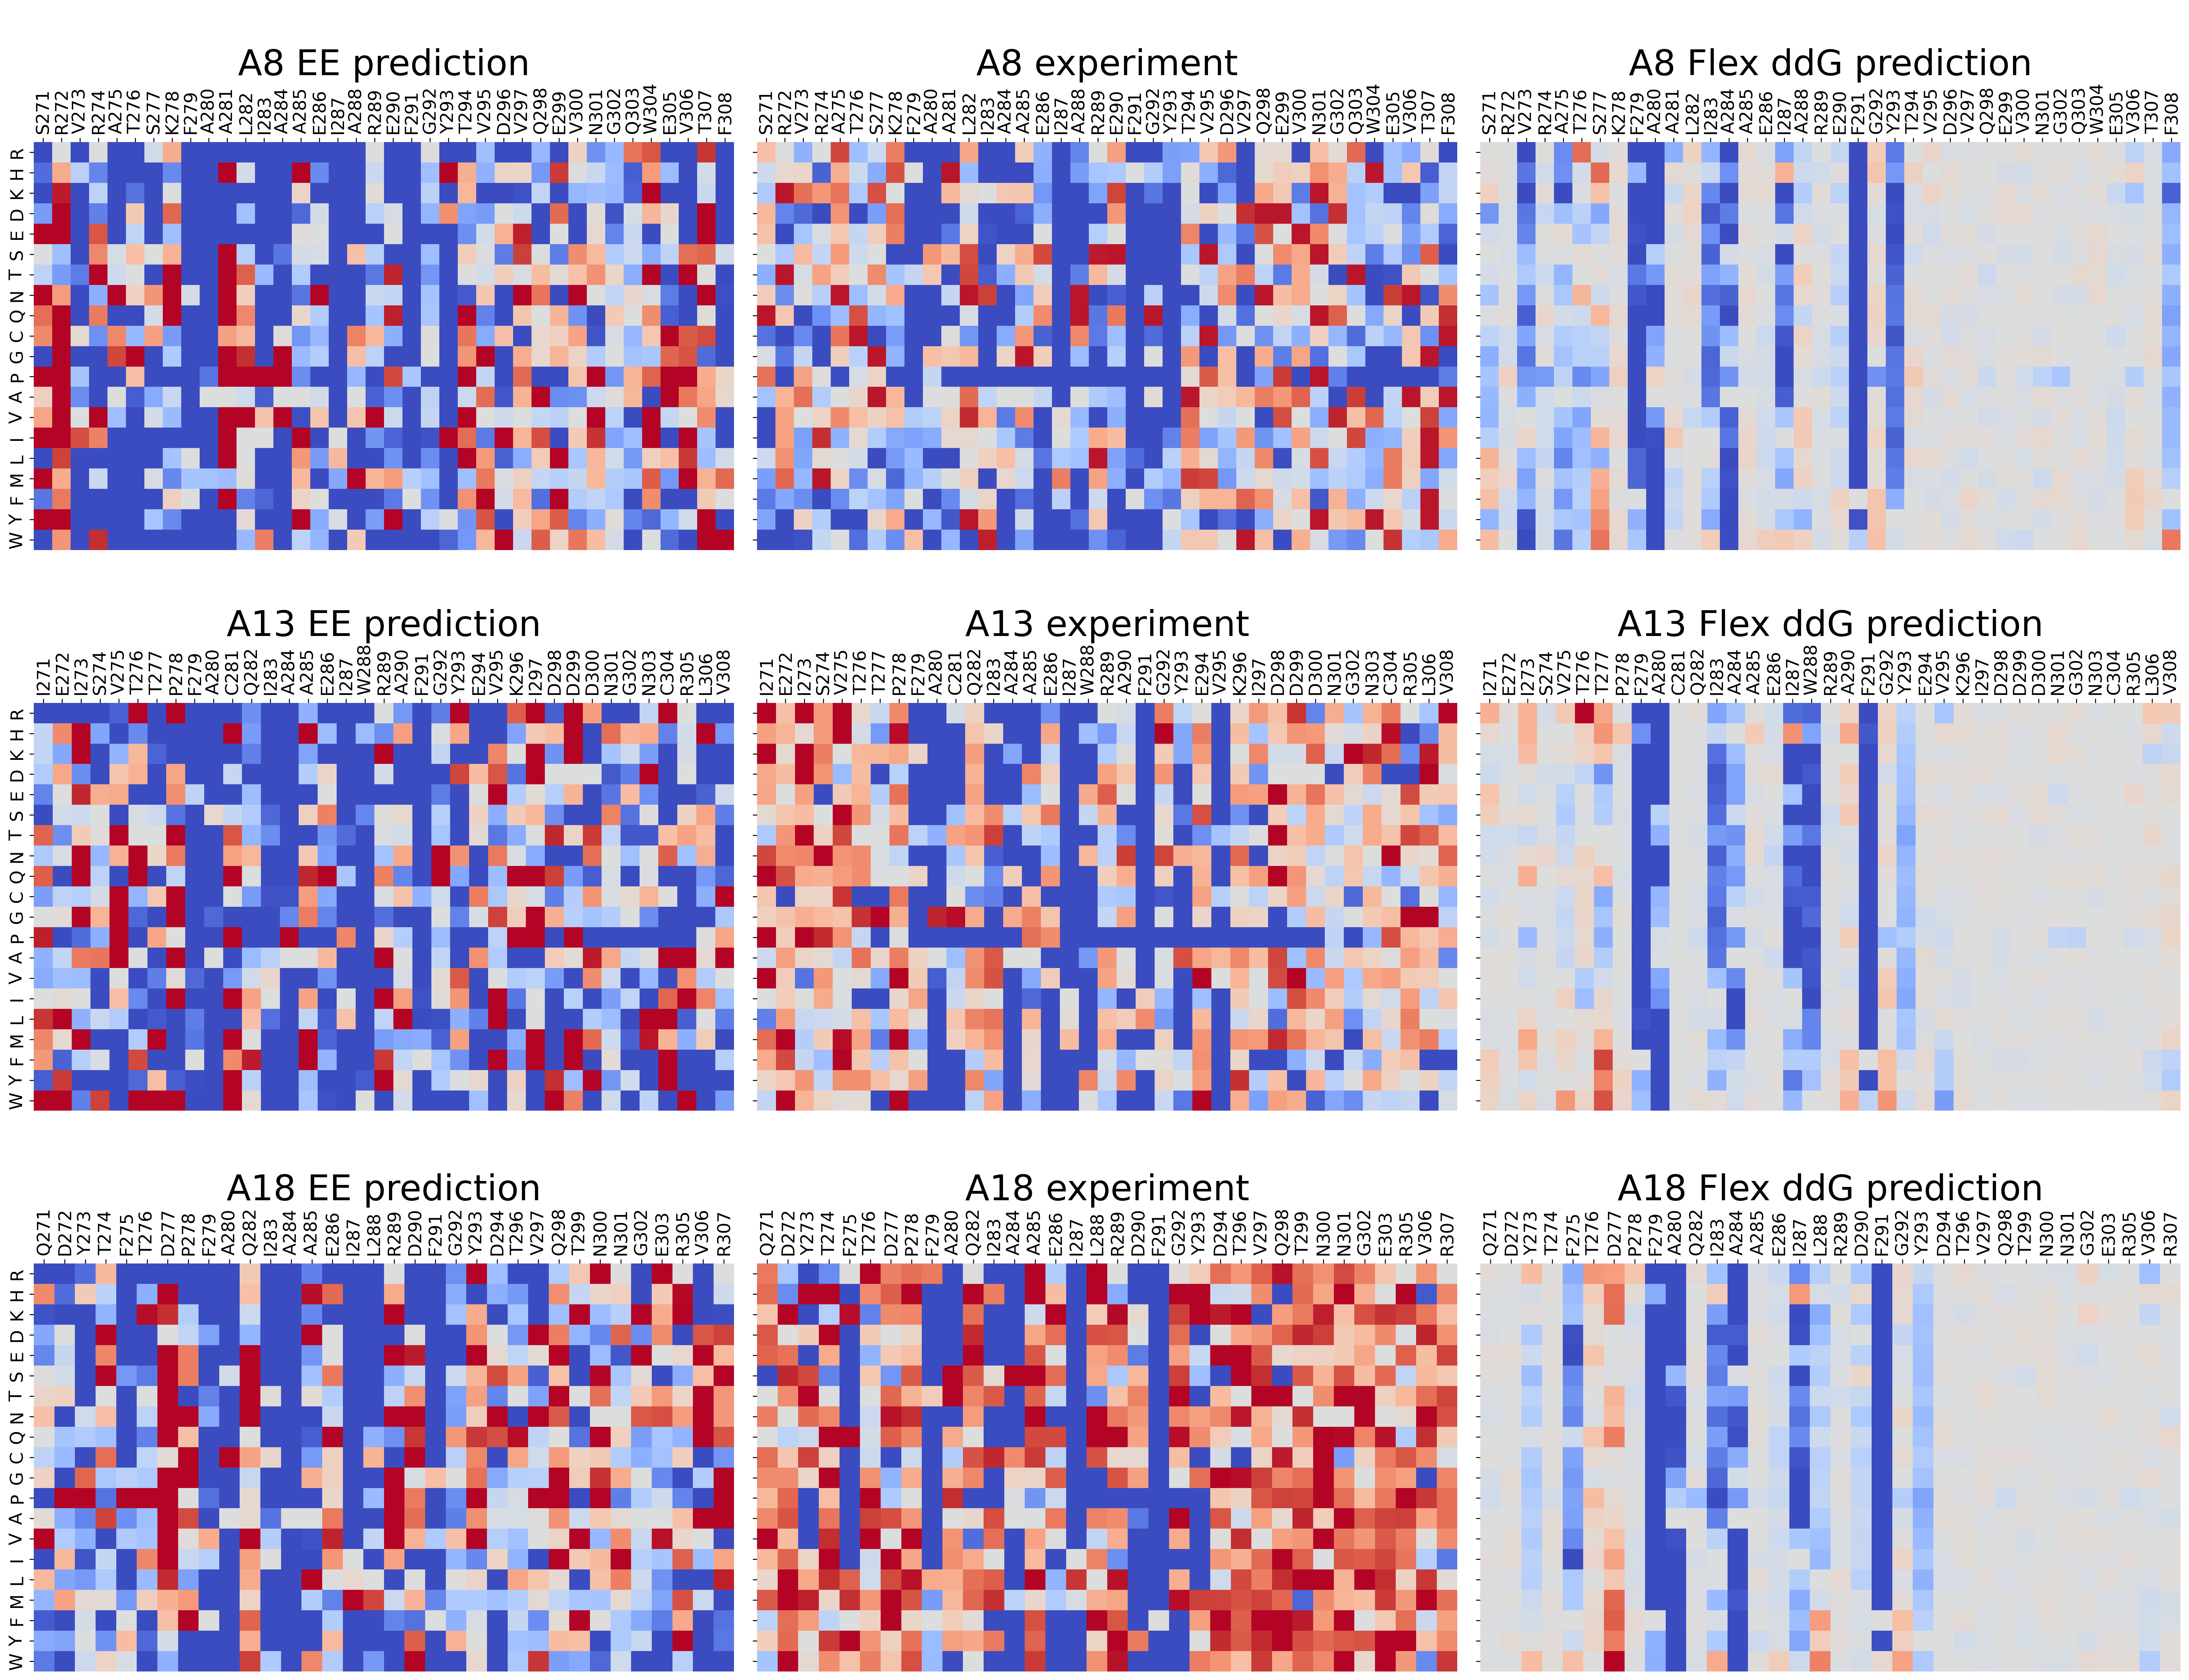

In [10]:
matrices = {'\nA8':[A8,A8_exp[A8.columns],A8_curr_ros[A8.columns]],
                  '\nA13':[A13,A13_exp[A13.columns],A13_curr_ros[A13.columns]],
                  '\nA18':[A18,A18_exp[A18.columns],A18_curr_ros[A18.columns]]}
types=['EE prediction','experiment','Flex ddG prediction']
plt.rcParams.update({'font.size': 15})
fig,axes = plt.subplots(3,3,figsize=(26,20),dpi=300,sharey=True)
ax_list = list(axes.flat)
for i,(key,value) in enumerate(matrices.items()):
    for j,val in enumerate(value):
        #val = scaler(val)
        ax = ax_list[j+3*i]
        ax.set_facecolor("black")
        t = types[j]
        min = -1.2
        max = 1.2
        label='kcal/mol'
        if i == 0:
            # im=sns.heatmap(val, cmap="coolwarm_r",ax=ax,vmin=min,vmax=max,annot=np.around(val.values,1), 
            #        annot_kws={'fontsize': 10},cbar=False)
            im=sns.heatmap(val, cmap="coolwarm_r",ax=ax,vmin=min,vmax=max,cbar=False)
        else:
            # sns.heatmap(val, cmap="coolwarm_r",ax=ax,vmin=min,vmax=max,annot=np.around(val.values,1), 
            #        annot_kws={'fontsize': 10},cbar=False)
            sns.heatmap(val, cmap="coolwarm_r",ax=ax,vmin=min,vmax=max,cbar=False)
        ax.xaxis.set_ticks_position('top')
        ax.set_title(key+' '+t,fontsize=30)
        ax.set_xticks(np.arange(0.5,len(val.columns)+ 0.5))
        ax.set_xticklabels(list(val.columns),rotation=90)
mappable = im.get_children()[0]
fig.tight_layout()
# fig.savefig('Heatmaps_figure5.png',dpi=300)
fig.savefig('Figure6_SSM_heatmap.png')

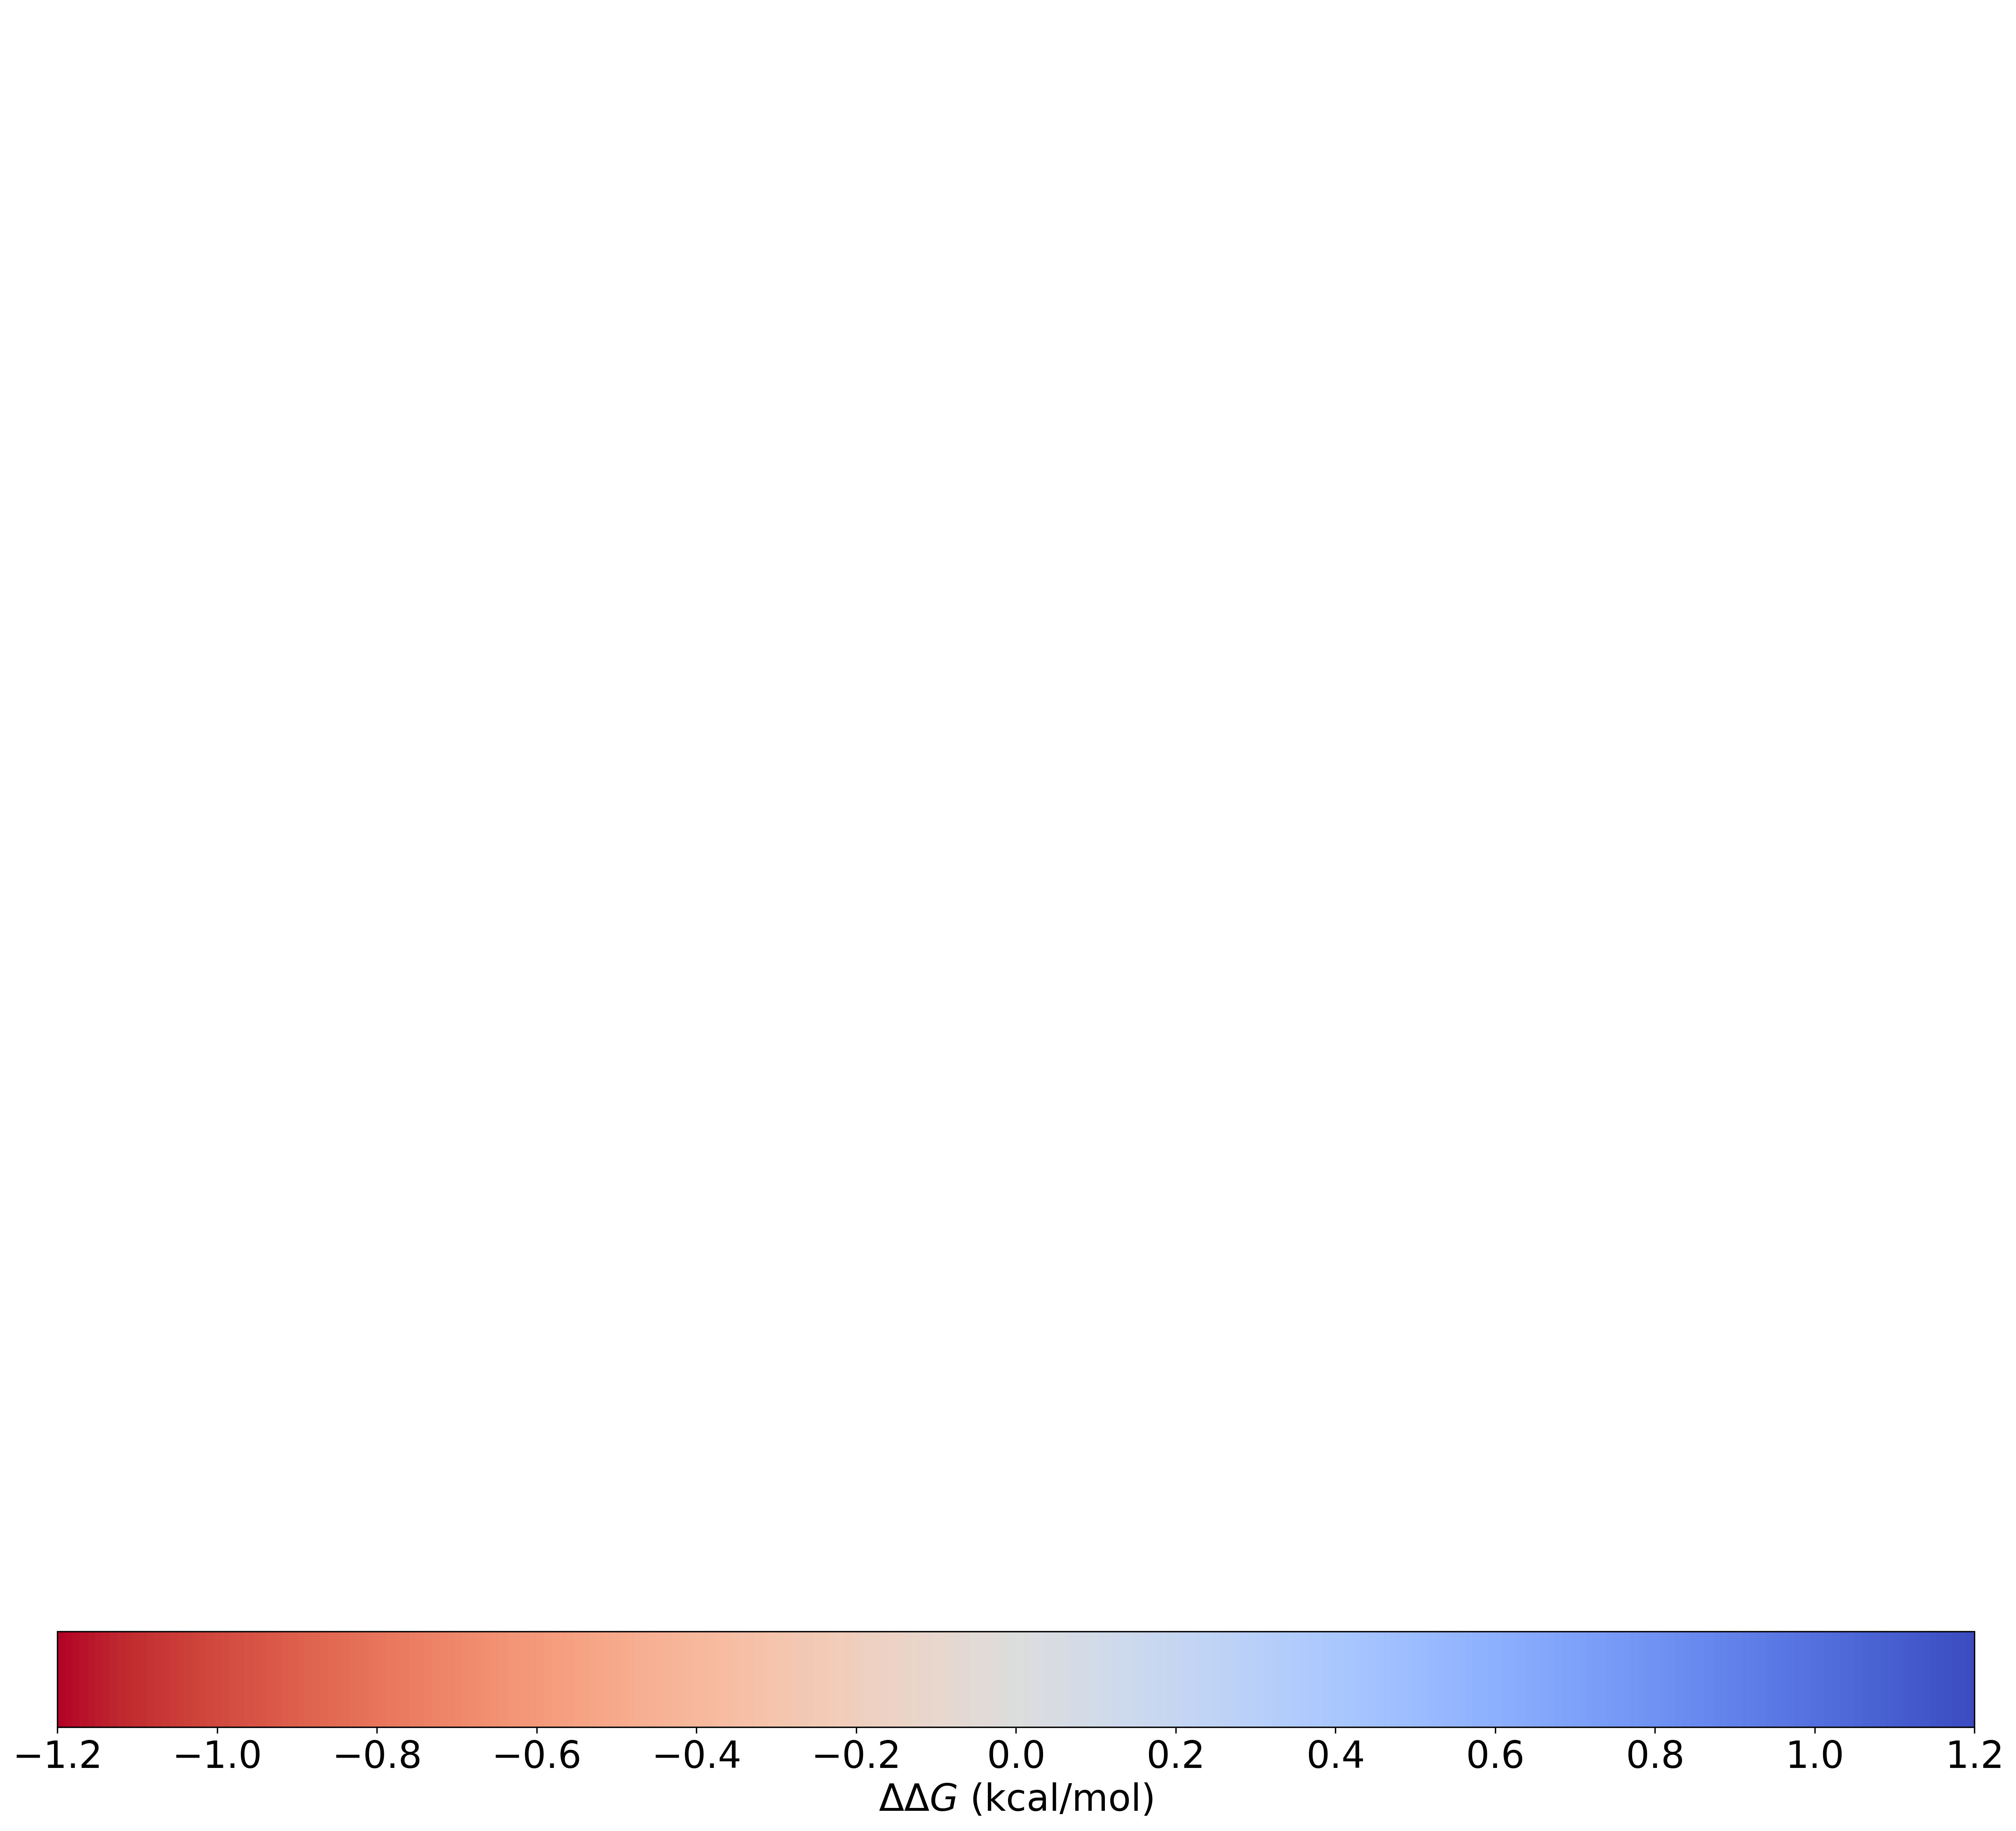

In [11]:
plt.close()
fig,ax= plt.subplots(figsize=(20,20),dpi=300)
ax.set_axis_off()       
# Display the color bar with a gradient legend      
cbar = plt.colorbar(mappable, ax=ax ,orientation = 'horizontal')
cbar.set_ticks(np.arange(-1.2,1.22,0.2))
cbar.set_label('$\Delta \Delta G$ (kcal/mol)',fontsize='x-large')     
cbar.ax.tick_params(labelsize='x-large')          
plt.savefig(f'Heatmap_colorbar.png',dpi=300,bbox_inches='tight', pad_inches=0, transparent=True)  

# Scatter PLots (figure 6.)

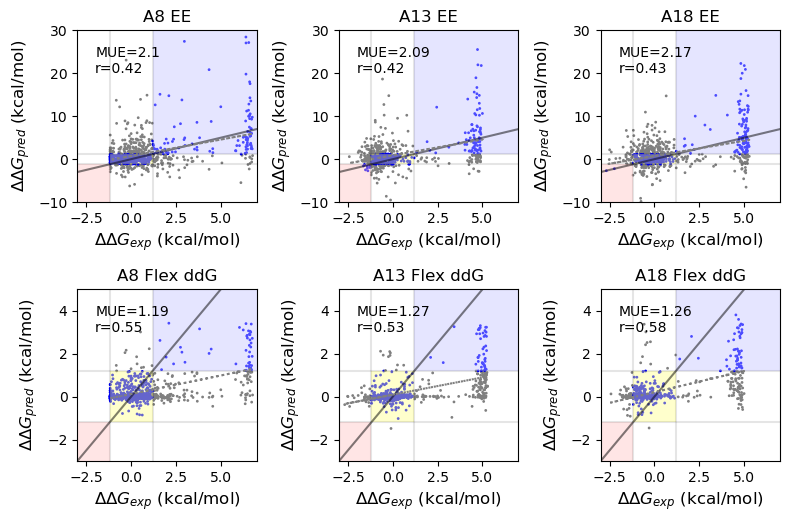

In [16]:
from matplotlib.patches import Rectangle

fig,axes = plt.subplots(2,3,figsize=(8,5.33)) # dpi=300)
plt.rcParams.update({'font.size': 10})
def makes_cutoff(v,cutoff):
    if (v >= cutoff) or (v <= -cutoff):
        value=1
    else:
        value=0
    return value
def make_scatter(x,y,ax=None,cutoff=1.2,ros=False,old=False):
    l = linregress(x, y)
    m=l.slope
    b=l.intercept
    r = l.rvalue
    
    MUE_fep = np.around(mue(x,y),2)
    correct=0
    total=0
    c = []
    for i,j in enumerate(x):
        total+=makes_cutoff(j,cutoff)
        if (j<-cutoff) and (y[i]<-cutoff):
            c.append('b')
            correct+=1
        elif (j>cutoff) and (y[i]>cutoff):
            c.append('b')
            correct+=1
        
        elif (j>-cutoff) and (j<cutoff) and (y[i]>-cutoff) and (y[i]<cutoff):
           c.append('b')
        else:
            c.append('grey')
        
    if not old:
        ax.scatter(x,y,s=1,color=c)
        ax.plot(np.arange(-10,8),np.arange(-10,8),c='k',alpha=0.5)
        ax.plot(x,m*x+b,linestyle=":",c='gray')
        label=f'MUE={MUE_fep}\nr={round(r,2)}'
        label2 = f'MUE={MUE_fep}\nslope={round(m,2)} kcal/mol,r={round(r,2)}\n$Sig.Corr.={round(correct/total,2)}$'
    else:
        ax.scatter(x,y,s=1,color='gray')
        ax.plot(np.arange(-10,8),np.arange(-10,8),c='k',alpha=0.5)
        ax.plot(x,m*x+b,linestyle=":",c='gray')
    if ros:
        if old:
            label = f'MUE={MUE_fep}\n$r={round(l.rvalue,2)}$'
            ax.text(-2.5,2,label)
        else:
            ax.text(-2,3,label)
    else:
        ax.text(-2,20,label)
    
# ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12 = axes.flat
ax1,ax2,ax3,ax4,ax5,ax6 = axes.flat

for ax in [ax1,ax2,ax3]:    # ,ax9,ax7,ax8
    ax.add_patch( Rectangle((1.2, 1.2), 
                        5.8, 28.8, 
                        fc = (0.75,0.75,1.0), #light blue 
                        ec ='none', 
                        lw = 10, alpha=0.4) ) 
    ax.add_patch( Rectangle((-1.2, -1.2), 
                        2.4, 2.4, 
                        fc =(1.0, 1.0, 0.5),  
                        ec ='none', 
                        lw = 10, alpha=0.4) ) 
    ax.add_patch( Rectangle((-1.2, -1.2), 
                        -2.8, -8.8, 
                        fc = (1.0, 0.75, 0.75),  #light red 
                        ec ='none', 
                        lw = 10, alpha=0.4) ) 

for ax in [ax4,ax5,ax6]:
    ax.add_patch( Rectangle((1.2, 1.2), 
                        5.8, 4.8, 
                        fc = (0.75,0.75,1.0), #light blue 
                        ec ='none', 
                        lw = 10, alpha=0.4) ) 
    ax.add_patch( Rectangle((-1.2, -1.2), 
                        2.4, 2.4, 
                        fc =(1.0, 1.0, 0.5),  
                        ec ='none', 
                        lw = 10, alpha=0.4) ) 
    ax.add_patch( Rectangle((-1.2, -1.2), 
                        -2.8, -2.8, 
                        fc = (1.0, 0.75, 0.75),  #light red 
                        ec ='none', 
                        lw = 10, alpha=0.4) ) 

    


x,y = np.concatenate(A8_exp[A8.columns].values),np.concatenate(A8.values)
make_scatter(x,y,ax=ax1)
ax1.set_title('A8 EE', fontsize=12)

x,y = np.concatenate(A13_exp[A13.columns].values),np.concatenate(A13.values)
make_scatter(x,y,ax=ax3)
ax2.set_title('A13 EE', fontsize=12)

x,y = np.concatenate(A18_exp[A18.columns].values),np.concatenate(A18.values)
make_scatter(x,y,ax=ax2)
ax3.set_title('A18 EE', fontsize=12)

x,y = np.concatenate(A8_exp[A8.columns].values),np.concatenate(A8_curr_ros[A8.columns].values)
make_scatter(x,y,ax=ax4,ros=True)
ax4.set_title('A8 Flex ddG')

x,y = np.concatenate(A13_exp[A13.columns].values),np.concatenate(A13_curr_ros[A13.columns].values)
make_scatter(x,y,ax=ax5,ros=True)
ax5.set_title('A13 Flex ddG')

x,y = np.concatenate(A18_exp[A18.columns].values),np.concatenate(A18_curr_ros[A18.columns].values)
make_scatter(x,y,ax=ax6,ros=True)
ax6.set_title('A18 Flex ddG')

for ax in axes.flat:
    ax.vlines(1.2,-50,50,color='k',linestyle="-",alpha=0.1)
    ax.hlines(1.2,-4,8,color='k',linestyle="-",alpha=0.1)
    ax.vlines(-1.2,-50,50,color='k',linestyle="-",alpha=0.1)
    ax.hlines(-1.2,-4,8,color='k',linestyle="-",alpha=0.1)
    ax.set_xlabel('$\Delta \Delta G_{exp}$ (kcal/mol)',fontsize=12)
    ax.set_ylabel('$\Delta \Delta G_{pred}$ (kcal/mol)',fontsize=12)
    
for ax in [ax1,ax2,ax3]:
    ax.set_xlim(-3,7)
    ax.set_ylim(-10,30)

for ax in [ax4,ax5,ax6]:
    ax.set_xlim(-3,7)
    ax.set_ylim(-3,5)
    
fig.tight_layout()
fig.savefig('scatter_all_results.pdf')